<a href="https://colab.research.google.com/github/Muhammad-Huzifa/Neural-Networks-and-Deep-Learning-Using-Pytorch-and-Tensor-Flow/blob/main/Hyperparameter_Tuning_using_Optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.optim as  optim
import torch.nn as nn

In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json

Saving kaggle (4).json to kaggle (4).json


{'kaggle (4).json': b'{"username":"huzifaulhaq","key":"a951046cf71fbb107f227b75825e14a2"}'}

In [ ]:
! pip install opendatasets

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/zalando-research/fashionmnist")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: huzifaulhaq
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/zalando-research/fashionmnist


100%|██████████| 68.8M/68.8M [00:00<00:00, 204MB/s]


In [ ]:
 import pandas as pd

In [ ]:
data = pd.read_csv('/content/fashionmnist/fashion-mnist_train.csv')

In [ ]:
data.head()


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device(type='cpu')

In [ ]:
torch.manual_seed(42)

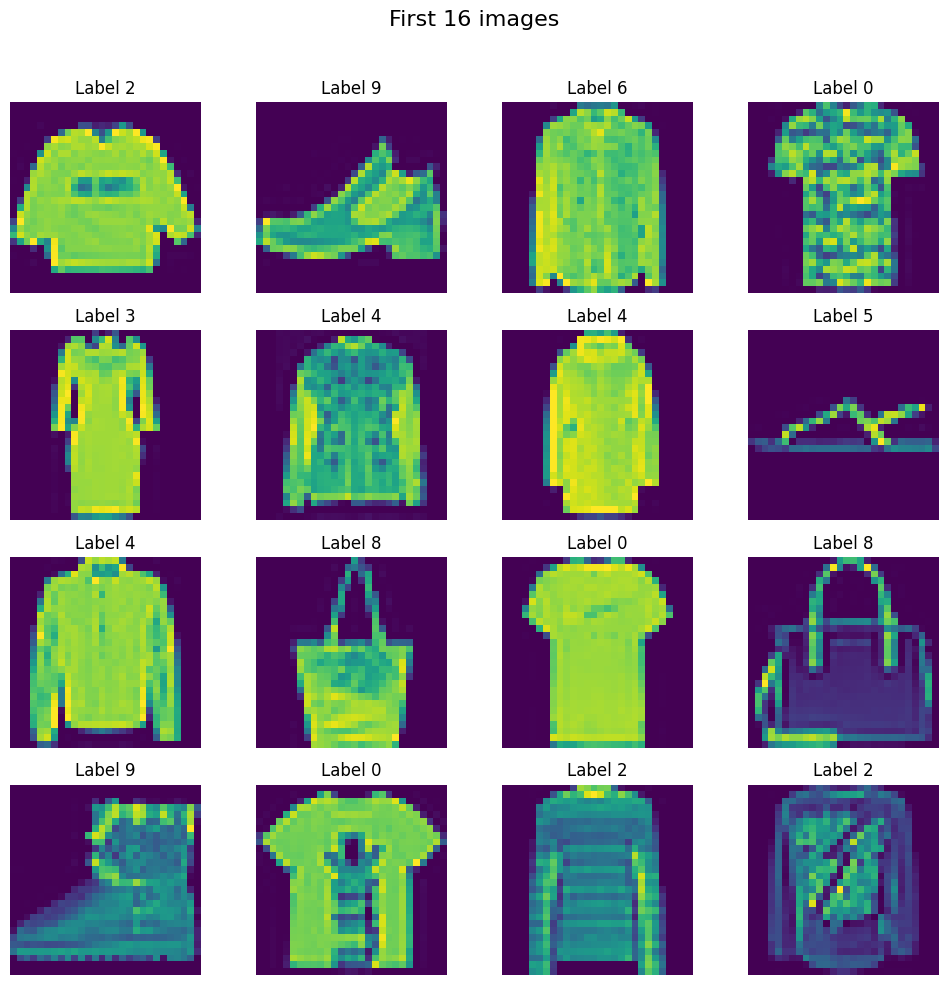

In [ ]:
fig , axes  = plt.subplots(4,4,figsize = (10,10))
fig.suptitle("First 16 images"  ,fontsize = 16)

for i , ax in enumerate(axes.flat):
  img = data.iloc[i , 1:].values.reshape(28,28)
  ax.imshow(img)
  ax.axis('off')
  ax.set_title(f"Label {data.iloc[i,0]}")
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

In [ ]:
X = data.iloc[: , 1:].values
y = data.iloc[: , 0].values



In [ ]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.2 , random_state = 42)

In [ ]:
X_train = X_train / 255
X_test = X_test/255

In [ ]:
class CustomDataset(Dataset):
  def __init__(self ,features, labels):
    self.features = torch.tensor(features , dtype = torch.float32)
    self.labels = torch.tensor(labels , dtype = torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self , idx):
    return self.features[idx] , self.labels[idx]

In [ ]:


train_dataset  = CustomDataset(X_train , y_train)
test_dataset = CustomDataset(X_test , y_test)

In [ ]:
train_loader = DataLoader(train_dataset , batch_size = 32 , shuffle = True ,pin_memory=True)
test_loader = DataLoader(test_dataset , batch_size = 32 , shuffle = False , pin_memory=True)

In [ ]:
class MyNN(nn.Module):

  def __init__(self, input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate):

    super().__init__()

    layers = []

    for i in range(num_hidden_layers):

      layers.append(nn.Linear(input_dim, neurons_per_layer))
      layers.append(nn.BatchNorm1d(neurons_per_layer))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(dropout_rate))
      input_dim = neurons_per_layer

    layers.append(nn.Linear(neurons_per_layer, output_dim))

    self.model = nn.Sequential(*layers)

  def forward(self, x):

    return self.model(x)

**Objective Function**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import optuna

def objective(trial):
    # Suggest hyperparameters
    hidden_layer = trial.suggest_int("hidden_layer", 1, 5)
    num_neurons = trial.suggest_int("num_neurons", 8, 128, step=8)

    # Initialize Model
    input_dim = 784  # Example for an image dataset (28x28 flattened)
    output_dim = 10  # Number of classes (e.g., digits 0-9)
    model = NN(input_dim, output_dim, hidden_layer, num_neurons)

    learning_rate = 0.01
    epochs = 50

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate , weight_decay=1e-4)

    # Set model to training mode
    model.train()

    # Training Loop
    for epoch in range(epochs):
        total_epoch_loss = 0  # Initialize loss

        for batch_features, batch_labels in train_loader:
            optimizer.zero_grad()  # Reset gradients
            outputs = model(batch_features)  # Forward pass
            loss = criterion(outputs, batch_labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            total_epoch_loss += loss.item()  # Track loss

        average_loss = total_epoch_loss / len(train_loader)  # Compute average loss
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {average_loss:.4f}")

    # Set model to evaluation mode
    model.eval()

    # Evaluate model accuracy
    with torch.no_grad():
        correct = 0
        total = 0
        for batch_features, batch_labels in test_loader:
            outputs = model(batch_features)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()

        accuracy = 100 * correct / total  # Compute accuracy

    # Track accuracy in Optuna
    trial.set_user_attr("accuracy", accuracy)

    return accuracy


In [ ]:
import optuna

In [ ]:
study  = optuna.create_study(direction = "maximize")
study.optimize(objective , n_trials =  10)

[I 2025-03-08 11:27:19,344] A new study created in memory with name: no-name-bbc67b17-4a6c-4bc5-98df-ff8b89945deb


Epoch [1/50], Loss: 1.7874
Epoch [2/50], Loss: 1.3377
Epoch [3/50], Loss: 1.2215
Epoch [4/50], Loss: 1.1636
Epoch [5/50], Loss: 1.1152
Epoch [6/50], Loss: 1.0939
Epoch [7/50], Loss: 1.0595
Epoch [8/50], Loss: 1.0398
Epoch [9/50], Loss: 1.0364
Epoch [10/50], Loss: 1.0089
Epoch [11/50], Loss: 1.0080
Epoch [12/50], Loss: 1.0001
Epoch [13/50], Loss: 0.9815
Epoch [14/50], Loss: 0.9750
Epoch [15/50], Loss: 0.9674
Epoch [16/50], Loss: 0.9639
Epoch [17/50], Loss: 0.9537
Epoch [18/50], Loss: 0.9529
Epoch [19/50], Loss: 0.9364
Epoch [20/50], Loss: 0.9363
Epoch [21/50], Loss: 0.9342
Epoch [22/50], Loss: 0.9241
Epoch [23/50], Loss: 0.9369
Epoch [24/50], Loss: 0.9225
Epoch [25/50], Loss: 0.9235
Epoch [26/50], Loss: 0.9025
Epoch [27/50], Loss: 0.9058
Epoch [28/50], Loss: 0.9137
Epoch [29/50], Loss: 0.9031
Epoch [30/50], Loss: 0.9028
Epoch [31/50], Loss: 0.8884
Epoch [32/50], Loss: 0.8957
Epoch [33/50], Loss: 0.8980
Epoch [34/50], Loss: 0.8994
Epoch [35/50], Loss: 0.8978
Epoch [36/50], Loss: 0.8877
E

[I 2025-03-08 11:31:26,598] Trial 0 finished with value: 80.96666666666667 and parameters: {'hidden_layer': 5, 'num_neurons': 24}. Best is trial 0 with value: 80.96666666666667.


Epoch [1/50], Loss: 1.3977
Epoch [2/50], Loss: 0.9176
Epoch [3/50], Loss: 0.8295
Epoch [4/50], Loss: 0.7750
Epoch [5/50], Loss: 0.7402
Epoch [6/50], Loss: 0.7059
Epoch [7/50], Loss: 0.6788
Epoch [8/50], Loss: 0.6713
Epoch [9/50], Loss: 0.6554
Epoch [10/50], Loss: 0.6432
Epoch [11/50], Loss: 0.6348
Epoch [12/50], Loss: 0.6131
Epoch [13/50], Loss: 0.6089
Epoch [14/50], Loss: 0.6036
Epoch [15/50], Loss: 0.5973
Epoch [16/50], Loss: 0.5928
Epoch [17/50], Loss: 0.5747
Epoch [18/50], Loss: 0.5684
Epoch [19/50], Loss: 0.5744
Epoch [20/50], Loss: 0.5664
Epoch [21/50], Loss: 0.5593
Epoch [22/50], Loss: 0.5494
Epoch [23/50], Loss: 0.5458
Epoch [24/50], Loss: 0.5455
Epoch [25/50], Loss: 0.5447
Epoch [26/50], Loss: 0.5385
Epoch [27/50], Loss: 0.5384
Epoch [28/50], Loss: 0.5330
Epoch [29/50], Loss: 0.5308
Epoch [30/50], Loss: 0.5222
Epoch [31/50], Loss: 0.5228
Epoch [32/50], Loss: 0.5192
Epoch [33/50], Loss: 0.5231
Epoch [34/50], Loss: 0.5124
Epoch [35/50], Loss: 0.5186
Epoch [36/50], Loss: 0.5168
E

[I 2025-03-08 11:36:01,306] Trial 1 finished with value: 87.81666666666666 and parameters: {'hidden_layer': 5, 'num_neurons': 56}. Best is trial 1 with value: 87.81666666666666.


Epoch [1/50], Loss: 1.5918
Epoch [2/50], Loss: 1.1987
Epoch [3/50], Loss: 1.0841
Epoch [4/50], Loss: 1.0213
Epoch [5/50], Loss: 0.9870
Epoch [6/50], Loss: 0.9603
Epoch [7/50], Loss: 0.9307
Epoch [8/50], Loss: 0.9142
Epoch [9/50], Loss: 0.9084
Epoch [10/50], Loss: 0.8871
Epoch [11/50], Loss: 0.8757
Epoch [12/50], Loss: 0.8692
Epoch [13/50], Loss: 0.8600
Epoch [14/50], Loss: 0.8643
Epoch [15/50], Loss: 0.8552
Epoch [16/50], Loss: 0.8436
Epoch [17/50], Loss: 0.8368
Epoch [18/50], Loss: 0.8360
Epoch [19/50], Loss: 0.8247
Epoch [20/50], Loss: 0.8283
Epoch [21/50], Loss: 0.8254
Epoch [22/50], Loss: 0.8192
Epoch [23/50], Loss: 0.8205
Epoch [24/50], Loss: 0.8103
Epoch [25/50], Loss: 0.8152
Epoch [26/50], Loss: 0.8004
Epoch [27/50], Loss: 0.8011
Epoch [28/50], Loss: 0.8068
Epoch [29/50], Loss: 0.7968
Epoch [30/50], Loss: 0.8048
Epoch [31/50], Loss: 0.7959
Epoch [32/50], Loss: 0.7946
Epoch [33/50], Loss: 0.7958
Epoch [34/50], Loss: 0.7955
Epoch [35/50], Loss: 0.7992
Epoch [36/50], Loss: 0.7989
E

[I 2025-03-08 11:39:30,418] Trial 2 finished with value: 80.825 and parameters: {'hidden_layer': 4, 'num_neurons': 24}. Best is trial 1 with value: 87.81666666666666.


Epoch [1/50], Loss: 0.8312
Epoch [2/50], Loss: 0.5760
Epoch [3/50], Loss: 0.5296
Epoch [4/50], Loss: 0.4978
Epoch [5/50], Loss: 0.4775
Epoch [6/50], Loss: 0.4611
Epoch [7/50], Loss: 0.4514
Epoch [8/50], Loss: 0.4366
Epoch [9/50], Loss: 0.4299
Epoch [10/50], Loss: 0.4200
Epoch [11/50], Loss: 0.4143
Epoch [12/50], Loss: 0.4097
Epoch [13/50], Loss: 0.4046
Epoch [14/50], Loss: 0.3951
Epoch [15/50], Loss: 0.3912
Epoch [16/50], Loss: 0.3881
Epoch [17/50], Loss: 0.3821
Epoch [18/50], Loss: 0.3768
Epoch [19/50], Loss: 0.3763
Epoch [20/50], Loss: 0.3736
Epoch [21/50], Loss: 0.3648
Epoch [22/50], Loss: 0.3637
Epoch [23/50], Loss: 0.3617
Epoch [24/50], Loss: 0.3546
Epoch [25/50], Loss: 0.3543
Epoch [26/50], Loss: 0.3506
Epoch [27/50], Loss: 0.3506
Epoch [28/50], Loss: 0.3451
Epoch [29/50], Loss: 0.3461
Epoch [30/50], Loss: 0.3409
Epoch [31/50], Loss: 0.3400
Epoch [32/50], Loss: 0.3383
Epoch [33/50], Loss: 0.3329
Epoch [34/50], Loss: 0.3323
Epoch [35/50], Loss: 0.3260
Epoch [36/50], Loss: 0.3270
E

[I 2025-03-08 11:42:20,269] Trial 3 finished with value: 89.01666666666667 and parameters: {'hidden_layer': 2, 'num_neurons': 80}. Best is trial 3 with value: 89.01666666666667.


Epoch [1/50], Loss: 0.8748
Epoch [2/50], Loss: 0.5927
Epoch [3/50], Loss: 0.5421
Epoch [4/50], Loss: 0.5126
Epoch [5/50], Loss: 0.4925
Epoch [6/50], Loss: 0.4763
Epoch [7/50], Loss: 0.4630
Epoch [8/50], Loss: 0.4467
Epoch [9/50], Loss: 0.4385
Epoch [10/50], Loss: 0.4265
Epoch [11/50], Loss: 0.4230
Epoch [12/50], Loss: 0.4142
Epoch [13/50], Loss: 0.4019
Epoch [14/50], Loss: 0.4009
Epoch [15/50], Loss: 0.3979
Epoch [16/50], Loss: 0.3909
Epoch [17/50], Loss: 0.3881
Epoch [18/50], Loss: 0.3807
Epoch [19/50], Loss: 0.3758
Epoch [20/50], Loss: 0.3707
Epoch [21/50], Loss: 0.3711
Epoch [22/50], Loss: 0.3631
Epoch [23/50], Loss: 0.3619
Epoch [24/50], Loss: 0.3590
Epoch [25/50], Loss: 0.3532
Epoch [26/50], Loss: 0.3511
Epoch [27/50], Loss: 0.3526
Epoch [28/50], Loss: 0.3469
Epoch [29/50], Loss: 0.3463
Epoch [30/50], Loss: 0.3404
Epoch [31/50], Loss: 0.3379
Epoch [32/50], Loss: 0.3336
Epoch [33/50], Loss: 0.3325
Epoch [34/50], Loss: 0.3276
Epoch [35/50], Loss: 0.3303
Epoch [36/50], Loss: 0.3239
E

[I 2025-03-08 11:46:04,925] Trial 4 finished with value: 89.3 and parameters: {'hidden_layer': 3, 'num_neurons': 112}. Best is trial 4 with value: 89.3.


Epoch [1/50], Loss: 2.1395
Epoch [2/50], Loss: 1.9250
Epoch [3/50], Loss: 1.8157
Epoch [4/50], Loss: 1.7458
Epoch [5/50], Loss: 1.6969
Epoch [6/50], Loss: 1.6735
Epoch [7/50], Loss: 1.6538
Epoch [8/50], Loss: 1.6333
Epoch [9/50], Loss: 1.6342
Epoch [10/50], Loss: 1.6293
Epoch [11/50], Loss: 1.6257
Epoch [12/50], Loss: 1.6131
Epoch [13/50], Loss: 1.6077
Epoch [14/50], Loss: 1.6140
Epoch [15/50], Loss: 1.6055
Epoch [16/50], Loss: 1.6027
Epoch [17/50], Loss: 1.6094
Epoch [18/50], Loss: 1.6052
Epoch [19/50], Loss: 1.6045
Epoch [20/50], Loss: 1.5977
Epoch [21/50], Loss: 1.5956
Epoch [22/50], Loss: 1.5951
Epoch [23/50], Loss: 1.5967
Epoch [24/50], Loss: 1.5956
Epoch [25/50], Loss: 1.5953
Epoch [26/50], Loss: 1.6027
Epoch [27/50], Loss: 1.5891
Epoch [28/50], Loss: 1.5959
Epoch [29/50], Loss: 1.5949
Epoch [30/50], Loss: 1.5956
Epoch [31/50], Loss: 1.5902
Epoch [32/50], Loss: 1.5927
Epoch [33/50], Loss: 1.5926
Epoch [34/50], Loss: 1.5916
Epoch [35/50], Loss: 1.5845
Epoch [36/50], Loss: 1.5877
E

[I 2025-03-08 11:49:46,177] Trial 5 finished with value: 38.25 and parameters: {'hidden_layer': 5, 'num_neurons': 8}. Best is trial 4 with value: 89.3.


Epoch [1/50], Loss: 0.9980
Epoch [2/50], Loss: 0.6905
Epoch [3/50], Loss: 0.6317
Epoch [4/50], Loss: 0.6015
Epoch [5/50], Loss: 0.5757
Epoch [6/50], Loss: 0.5589
Epoch [7/50], Loss: 0.5525
Epoch [8/50], Loss: 0.5340
Epoch [9/50], Loss: 0.5302
Epoch [10/50], Loss: 0.5210
Epoch [11/50], Loss: 0.5161
Epoch [12/50], Loss: 0.5034
Epoch [13/50], Loss: 0.4988
Epoch [14/50], Loss: 0.4998
Epoch [15/50], Loss: 0.4935
Epoch [16/50], Loss: 0.4885
Epoch [17/50], Loss: 0.4860
Epoch [18/50], Loss: 0.4803
Epoch [19/50], Loss: 0.4782
Epoch [20/50], Loss: 0.4768
Epoch [21/50], Loss: 0.4679
Epoch [22/50], Loss: 0.4685
Epoch [23/50], Loss: 0.4657
Epoch [24/50], Loss: 0.4616
Epoch [25/50], Loss: 0.4590
Epoch [26/50], Loss: 0.4580
Epoch [27/50], Loss: 0.4605
Epoch [28/50], Loss: 0.4514
Epoch [29/50], Loss: 0.4539
Epoch [30/50], Loss: 0.4538
Epoch [31/50], Loss: 0.4468
Epoch [32/50], Loss: 0.4457
Epoch [33/50], Loss: 0.4462
Epoch [34/50], Loss: 0.4462
Epoch [35/50], Loss: 0.4420
Epoch [36/50], Loss: 0.4408
E

[I 2025-03-08 11:52:19,350] Trial 6 finished with value: 87.21666666666667 and parameters: {'hidden_layer': 2, 'num_neurons': 40}. Best is trial 4 with value: 89.3.


Epoch [1/50], Loss: 1.0173
Epoch [2/50], Loss: 0.6954
Epoch [3/50], Loss: 0.6293
Epoch [4/50], Loss: 0.6014
Epoch [5/50], Loss: 0.5767
Epoch [6/50], Loss: 0.5581
Epoch [7/50], Loss: 0.5489
Epoch [8/50], Loss: 0.5339
Epoch [9/50], Loss: 0.5284
Epoch [10/50], Loss: 0.5205
Epoch [11/50], Loss: 0.5127
Epoch [12/50], Loss: 0.5051
Epoch [13/50], Loss: 0.5019
Epoch [14/50], Loss: 0.4944
Epoch [15/50], Loss: 0.4925
Epoch [16/50], Loss: 0.4855
Epoch [17/50], Loss: 0.4829
Epoch [18/50], Loss: 0.4779
Epoch [19/50], Loss: 0.4728
Epoch [20/50], Loss: 0.4687
Epoch [21/50], Loss: 0.4726
Epoch [22/50], Loss: 0.4633
Epoch [23/50], Loss: 0.4646
Epoch [24/50], Loss: 0.4583
Epoch [25/50], Loss: 0.4587
Epoch [26/50], Loss: 0.4592
Epoch [27/50], Loss: 0.4552
Epoch [28/50], Loss: 0.4574
Epoch [29/50], Loss: 0.4495
Epoch [30/50], Loss: 0.4468
Epoch [31/50], Loss: 0.4441
Epoch [32/50], Loss: 0.4396
Epoch [33/50], Loss: 0.4443
Epoch [34/50], Loss: 0.4415
Epoch [35/50], Loss: 0.4404
Epoch [36/50], Loss: 0.4442
E

[I 2025-03-08 11:54:53,991] Trial 7 finished with value: 87.55 and parameters: {'hidden_layer': 2, 'num_neurons': 40}. Best is trial 4 with value: 89.3.


Epoch [1/50], Loss: 1.0172
Epoch [2/50], Loss: 0.6739
Epoch [3/50], Loss: 0.6145
Epoch [4/50], Loss: 0.5780
Epoch [5/50], Loss: 0.5553
Epoch [6/50], Loss: 0.5343
Epoch [7/50], Loss: 0.5200
Epoch [8/50], Loss: 0.5051
Epoch [9/50], Loss: 0.4979
Epoch [10/50], Loss: 0.4819
Epoch [11/50], Loss: 0.4768
Epoch [12/50], Loss: 0.4665
Epoch [13/50], Loss: 0.4638
Epoch [14/50], Loss: 0.4546
Epoch [15/50], Loss: 0.4514
Epoch [16/50], Loss: 0.4393
Epoch [17/50], Loss: 0.4357
Epoch [18/50], Loss: 0.4295
Epoch [19/50], Loss: 0.4259
Epoch [20/50], Loss: 0.4194
Epoch [21/50], Loss: 0.4217
Epoch [22/50], Loss: 0.4191
Epoch [23/50], Loss: 0.4072
Epoch [24/50], Loss: 0.4105
Epoch [25/50], Loss: 0.4013
Epoch [26/50], Loss: 0.4016
Epoch [27/50], Loss: 0.4001
Epoch [28/50], Loss: 0.3931
Epoch [29/50], Loss: 0.3954
Epoch [30/50], Loss: 0.3859
Epoch [31/50], Loss: 0.3876
Epoch [32/50], Loss: 0.3830
Epoch [33/50], Loss: 0.3839
Epoch [34/50], Loss: 0.3801
Epoch [35/50], Loss: 0.3754
Epoch [36/50], Loss: 0.3743
E

[I 2025-03-08 11:59:04,134] Trial 8 finished with value: 88.73333333333333 and parameters: {'hidden_layer': 4, 'num_neurons': 96}. Best is trial 4 with value: 89.3.


Epoch [1/50], Loss: 1.0873
Epoch [2/50], Loss: 0.7366
Epoch [3/50], Loss: 0.6653
Epoch [4/50], Loss: 0.6264
Epoch [5/50], Loss: 0.5991
Epoch [6/50], Loss: 0.5784
Epoch [7/50], Loss: 0.5671
Epoch [8/50], Loss: 0.5511
Epoch [9/50], Loss: 0.5343
Epoch [10/50], Loss: 0.5317
Epoch [11/50], Loss: 0.5148
Epoch [12/50], Loss: 0.5058
Epoch [13/50], Loss: 0.4966
Epoch [14/50], Loss: 0.4975
Epoch [15/50], Loss: 0.4892
Epoch [16/50], Loss: 0.4829
Epoch [17/50], Loss: 0.4783
Epoch [18/50], Loss: 0.4697
Epoch [19/50], Loss: 0.4706
Epoch [20/50], Loss: 0.4634
Epoch [21/50], Loss: 0.4606
Epoch [22/50], Loss: 0.4599
Epoch [23/50], Loss: 0.4622
Epoch [24/50], Loss: 0.4504
Epoch [25/50], Loss: 0.4409
Epoch [26/50], Loss: 0.4481
Epoch [27/50], Loss: 0.4357
Epoch [28/50], Loss: 0.4293
Epoch [29/50], Loss: 0.4363
Epoch [30/50], Loss: 0.4293
Epoch [31/50], Loss: 0.4257
Epoch [32/50], Loss: 0.4272
Epoch [33/50], Loss: 0.4224
Epoch [34/50], Loss: 0.4236
Epoch [35/50], Loss: 0.4205
Epoch [36/50], Loss: 0.4213
E

[I 2025-03-08 12:03:04,473] Trial 9 finished with value: 88.40833333333333 and parameters: {'hidden_layer': 4, 'num_neurons': 72}. Best is trial 4 with value: 89.3.
